In [ ]:
import sys
import os
import importlib
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta

parent_dir = os.path.dirname(os.path.abspath(''))
sys.path.append(parent_dir)

import data_import
importlib.reload(data_import)

TARDIS_TYPE = 'derivative_ticker'
INSTRUMENT = 'btcusdt'
START = '2020-01-01'
END = '2024-10-18'
EXCHANGE = 'binance-futures'

all_data = data_import.normalize_tardis_data(EXCHANGE, TARDIS_TYPE, START, END, INSTRUMENT, parent_dir)

In [1]:

import os
import sys
import pandas as pd
from pathlib import Path
import importlib

# Add the project directory to the Python path
project_dir = Path(os.getcwd()).parent
sys.path.append(str(project_dir))

# Reload any changes to sub modules
import config
importlib.reload(config)
import utilities
importlib.reload(utilities)

# Import custom modules from the 'utilities' package
from utilities import normalize_tardis_data, plot_funding_rate, load_data, preprocess_data

# Import configuration constants from 'config.py'
from config import (
    BINANCE_BTC_PERP_CSV,
    EXCHANGE,
    TARDIS_TYPE,
    START_DATE,
    END_DATE,
    INSTRUMENT,
    NORMALIZED_DATA_DIR
)

# Load the data
data_path = BINANCE_BTC_PERP_CSV

# Load data from CSV if normalized, or use normalize_tardis_data for raw data
if os.path.exists(data_path):
    data = load_data(data_path, do_preview=False)
else:
    data = normalize_tardis_data(
        exchange=EXCHANGE,
        tardis_type=TARDIS_TYPE,
        start_date=START_DATE,
        end_date=END_DATE,
        instrument=INSTRUMENT,
        raw_data_dir=os.path.join(project_dir, 'data', 'raw_data'),
        normalized_data_dir=NORMALIZED_DATA_DIR
    )
    # Since normalize_tardis_data now saves the combined data to CSV, we can load it
    data = load_data(data_path, do_preview=False)

# Preprocess the data
data = preprocess_data(data)

# Overview of the data
data.describe()

,local_timestamp,funding_timestamp,funding_rate,predicted_funding_rate,open_interest,last_price,index_price,mark_price
count,4.217900e+04,4.217900e+04,42179.000000,42179.0,42179.000000,42179.000000,42179.000000,42179.000000
mean,1.653453e+15,1.648364e+15,0.000135,0.0,69316.704713,34058.074838,32850.126122,33956.676761
std,4.439943e+13,1.021454e+14,0.000250,0.0,35134.191873,18387.908777,20115.708050,18464.010288
min,0.000000e+00,0.000000e+00,-0.003000,0.0,0.000000,0.000000,0.000000,0.000000
25%,1.615703e+15,1.615334e+15,0.000040,0.0,39350.334500,19285.000000,19226.870483,19220.630351
50%,1.653458e+15,1.653293e+15,0.000100,0.0,75588.837000,30365.100000,30332.773077,30322.817893
75%,1.691264e+15,1.691251e+15,0.000100,0.0,92232.202000,47686.110000,47625.147521,47641.960000
max,1.729210e+15,1.729210e+15,0.003000,0.0,170201.720000,73649.900000,73574.732727,73647.075311


In [34]:
def data_save(data):
    """
    Save the data to a csv and reinstate the timestamp column.
    We also "round" the data to the nearest hour mark so all 
    entries are equally spaced.
    """
    df = data.copy()

    data_start = datetime(2020, 1, 1)

    df['timestamp'] = (data_start + (df.index * timedelta(hours=1))).astype('int64')
    df.to_csv("../normalized_datasets/binance_btc_perp.csv", index=False)

data_save(all_data)

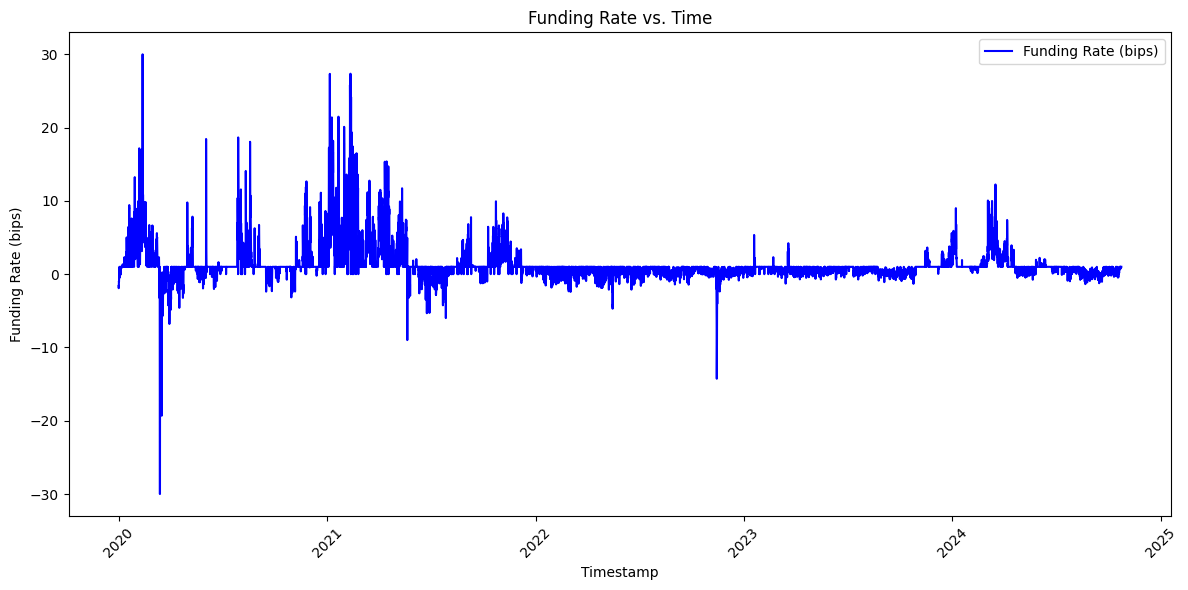

In [5]:
plot_funding_rate(data)

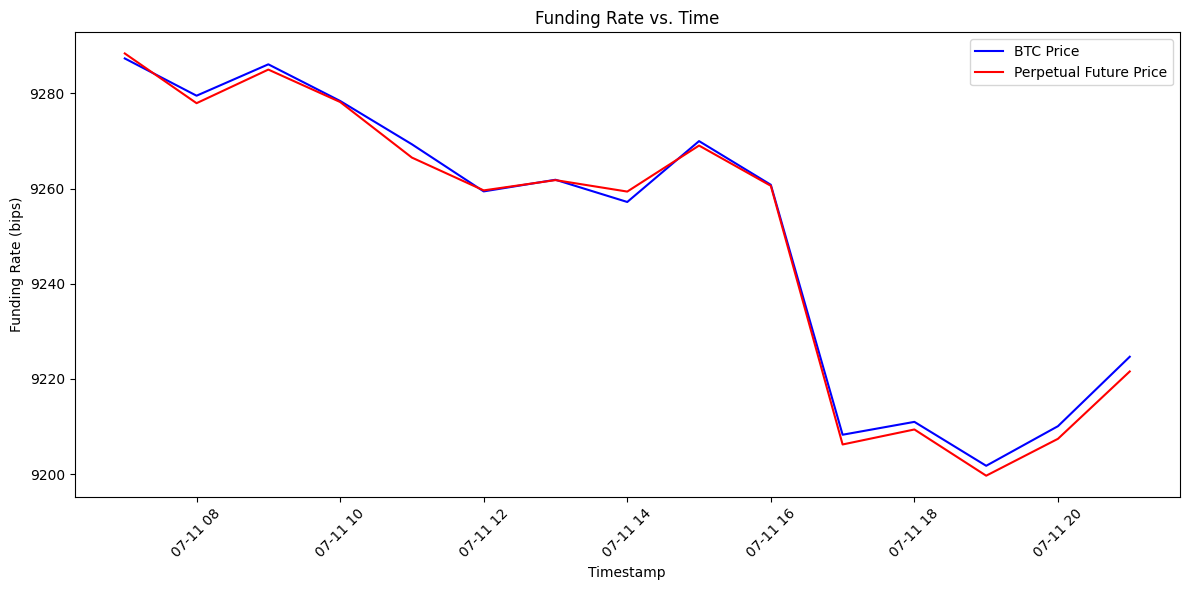

In [20]:
import matplotlib.pyplot as plt
def plot_price_data(df):
    # Make a copy of the DataFrame and convert the timestamp
    df = df.copy()
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='us', utc=True)
    df = df.set_index('timestamp')

    # Plot the funding rate, scaled for better visualization
    plt.figure(figsize=(12, 6))
    plt.plot(df.index, df['mark_price'], label=f'BTC Price', color='blue')
    plt.plot(df.index, df['last_price'], label='Perpetual Future Price', color='red')
    plt.xticks(rotation=45)
    plt.xlabel("Timestamp")
    plt.ylabel("Funding Rate (bips)")
    plt.title("Funding Rate vs. Time")
    plt.legend()
    plt.tight_layout()  # Adjust layout to avoid clipping
    plt.show()

# base=4300
base=4600
plot_price_data(data[base+15:base+30])

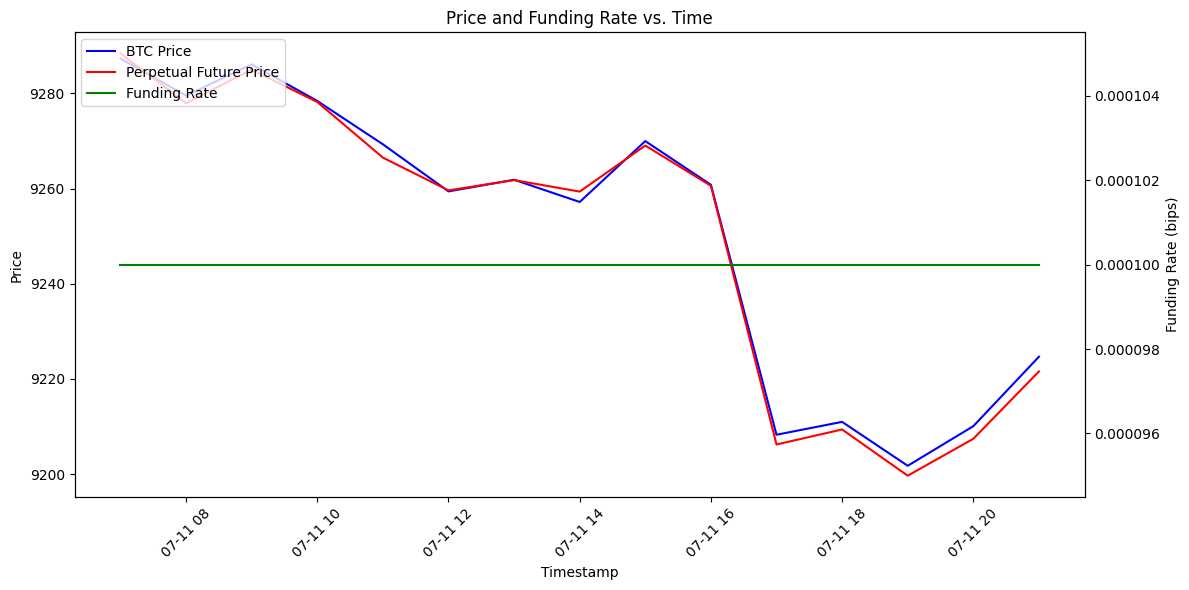

In [22]:
import matplotlib.pyplot as plt

def plot_price_data(df):
    # Make a copy of the DataFrame and convert the timestamp
    df = df.copy()
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='us', utc=True)
    df = df.set_index('timestamp')

    # Create figure and primary axis
    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Plot price data on primary axis
    ax1.plot(df.index, df['mark_price'], label='BTC Price', color='blue')
    ax1.plot(df.index, df['last_price'], label='Perpetual Future Price', color='red')
    ax1.set_xlabel('Timestamp')
    ax1.set_ylabel('Price')
    ax1.tick_params(axis='x', rotation=45)

    # Create secondary axis
    ax2 = ax1.twinx()
    
    # Plot funding rate on secondary axis
    ax2.plot(df.index, df['funding_rate'], label='Funding Rate', color='green')
    ax2.set_ylabel('Funding Rate (bips)')
    
    # Add horizontal line at y=0 on secondary axis
    # ax2.axhline(y=0, color='gray', linestyle='--', alpha=0.5)

    # Combine legends from both axes
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

    plt.title('Price and Funding Rate vs. Time')
    plt.tight_layout()
    plt.show()

# base=4600
plot_price_data(data[base+15:base+30])